In [ ]:
!pip install transformers
!pip install tweepy
!pip install tqdm

!pip install wordcloud
!pip install TurkishStemmer
!pip install sklearn
!pip install nltk
!pip install pycountry

In [3]:
import tweepy

# Data Manipulation
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

# Bert Model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Metin Ön İşleme
from TurkishStemmer import TurkishStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings(action = 'ignore')

import requests

In [4]:
consumer_key = 'M4gvZwp9UWrYUwiHoMOUlj4Ao'
consumer_secret = 'i3yFIonfKOlfUaFelAoroLCazBoeSMZqK0A8gwAmuf7Pttl8r1' 
access_token = '2825908409-8ka7j54bh3rSjRPfv2n3UAglbFbbbvFk2GuIb99'
access_token_secret ='Tmzo3DWql3dPz7aKOpvqc7LzLUabA3Dbrz7geOwpkkBSS'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [5]:
tweets_list = []
text_query = 'Mersin'
count = 100

for tweet in api.search(q=text_query, count=count, lang='tr-tr'):
    tweets_list.append((tweet.created_at,tweet.id,tweet.text))

In [6]:
tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
tweets.head()

,Tarih,Tweet_id,Text
0,2022-06-16 16:01:03,1537465284998713345,"RT @penceretv2: Başkan Seçer: ""İmar Dilinde Ra..."
1,2022-06-16 16:00:49,1537465226039263238,RT @Hsn548824641: Mersin merkezli dört ilde ya...
2,2022-06-16 15:59:59,1537465016223420417,Mersin Emniyet Müdürlüğü Kerem'i hayallerine k...
3,2022-06-16 15:59:41,1537464942231597058,"RT @penceretv2: Başkan Seçer: ""İmar Dilinde Ra..."
4,2022-06-16 15:59:25,1537464874334298113,RT @zombilice: Bu millete neden bu kadar düşma...


In [29]:
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

In [9]:
sentiment_analysis_pipeline("Çok kötü deney")


[{'label': 'negative', 'score': 0.9993816614151001}]

In [10]:
sentiment_result=[]
for text in tqdm(tweets.Text):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)

100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


In [11]:
sentiment_result = pd.DataFrame(sentiment_result)
sentiment_result.head()

,label,score
0,positive,0.945607
1,positive,0.995564
2,positive,0.917065
3,positive,0.945607
4,negative,0.550784


In [12]:
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([tweets, sentiment_result],axis=1)
tweets.label = tweets.label.map({'positive':1,'negative':0})
tweets.head()

,Tarih,Tweet_id,Text,label,score
0,2022-06-16 16:01:03,1537465284998713345,"RT @penceretv2: Başkan Seçer: ""İmar Dilinde Ra...",1,0.945607
1,2022-06-16 16:00:49,1537465226039263238,RT @Hsn548824641: Mersin merkezli dört ilde ya...,1,0.995564
2,2022-06-16 15:59:59,1537465016223420417,Mersin Emniyet Müdürlüğü Kerem'i hayallerine k...,1,0.917065
3,2022-06-16 15:59:41,1537464942231597058,"RT @penceretv2: Başkan Seçer: ""İmar Dilinde Ra...",1,0.945607
4,2022-06-16 15:59:25,1537464874334298113,RT @zombilice: Bu millete neden bu kadar düşma...,0,0.550784


In [13]:
class TwitterSentimentAnalyser:
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret, keyword, tweetCount):
        self.keyword = keyword
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        self.tweetCount = tweetCount
        
    def getTwitterData(self):
        tweets_list = []
        
        for tweet in api.search(q=self.keyword, count=self.tweetCount, lang='tr-tr'):
            tweets_list.append((tweet.created_at,tweet.id,tweet.text))
            
        self.tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
            
    def bertPipeline(self):
        # Eğitilmiş Ağırlıkların Yüklenmesi
        model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
        tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

        self.sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
        
    def sentimentPrediction(self):
        self.sentiment_result=[]
        for text in tqdm(self.tweets.Text):
            result = sentiment_analysis_pipeline(text)[0]
            self.sentiment_result.append(result)
        
        self.sentiment_result = pd.DataFrame(self.sentiment_result)
        self.tweets = pd.concat([self.tweets, self.sentiment_result],axis=1)
        self.tweets.label = self.tweets.label.map({'positive':1,'negative':0})

In [14]:
twst = TwitterSentimentAnalyser(consumer_key = consumer_key, consumer_secret = consumer_secret,
                                access_token = access_token, access_token_secret = access_token_secret,
                                keyword='mersin', tweetCount=100)

In [15]:
twst.getTwitterData()
twst.tweets.head()

,Tarih,Tweet_id,Text
0,2022-06-16 16:02:13,1537465579124273152,"RT @avcahitozkan: ❝Bülbül güle,karga çöplüğe g..."
1,2022-06-16 16:01:57,1537465510924787713,RT @alitilkici38: Mhp Mersin Milletvekili Sayı...
2,2022-06-16 16:01:42,1537465449377669120,RT @DUDUKCU19: 🔹Mersin/Akdeniz Belediye Meclis...
3,2022-06-16 16:01:39,1537465435070861313,"Özel Sektör Öğretmenleri Sendikası ""Özel Sektö..."
4,2022-06-16 16:01:30,1537465400040071169,RT @GSB_Mersin: 📌@gencliksporbak himayelerinde...


In [16]:
twst.bertPipeline()


In [17]:
twst.sentimentPrediction()
twst.tweets.head()

100%|██████████| 75/75 [00:11<00:00,  6.30it/s]


,Tarih,Tweet_id,Text,label,score
0,2022-06-16 16:02:13,1537465579124273152,"RT @avcahitozkan: ❝Bülbül güle,karga çöplüğe g...",1,0.860950
1,2022-06-16 16:01:57,1537465510924787713,RT @alitilkici38: Mhp Mersin Milletvekili Sayı...,1,0.532769
2,2022-06-16 16:01:42,1537465449377669120,RT @DUDUKCU19: 🔹Mersin/Akdeniz Belediye Meclis...,0,0.948420
3,2022-06-16 16:01:39,1537465435070861313,"Özel Sektör Öğretmenleri Sendikası ""Özel Sektö...",0,0.948253
4,2022-06-16 16:01:30,1537465400040071169,RT @GSB_Mersin: 📌@gencliksporbak himayelerinde...,1,0.981121


In [18]:
print(f"{twst.keyword} Hakkında {twst.tweets.Tarih.min()} ile {twst.tweets.Tarih.max()} arasında atılan {len(twst.tweets)} adet Tweet'in Pozitiflik Oranı: {twst.tweets.label.mean()}")


mersin Hakkında 2022-06-16 15:32:50 ile 2022-06-16 16:02:13 arasında atılan 75 adet Tweet'in Pozitiflik Oranı: 0.5866666666666667


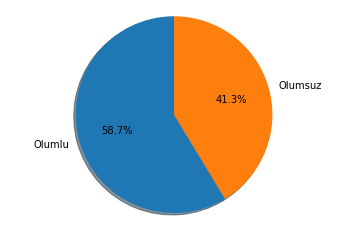

In [20]:
labels = twst.tweets.label.map({1:'Olumlu',0:'Olumsuz'}).value_counts().index.values
sizes = twst.tweets.label.value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [21]:
data = twst.tweets.copy()


In [22]:
def preProcess(ReviewText):
    #Verideki <br> taglarını kaldır.
    ReviewText = ReviewText.str.lower()
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ') 
    #Verideki Linkleri Kaldır.
    ReviewText = ReviewText.str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|#[a-zA-Z]+|$[a-zA-Z]+|@[a-zA-Z]+|[,.^_$*%-;鶯!?:]', ' ') 
    
    return ReviewText

data['Text'] = preProcess(data['Text'])

In [23]:
# Kök Bulma
stemmer = TurkishStemmer()

stemmed_lists = []
for index in tqdm(data.index):
    mini_l = []
    for text in data.loc[index]['Text'].split(" "):
        mini_l.append(stemmer.stem(text))

    big_text=" "
    for char in mini_l:
        big_text = big_text + " " + char
    stemmed_lists.append(big_text)
    
data['stemmed'] = stemmed_lists

100%|██████████| 75/75 [00:00<00:00, 1323.34it/s]


In [24]:
data.head()

,Tarih,Tweet_id,Text,label,score,stemmed
0,2022-06-16 16:02:13,1537465579124273152,rt ❝bülbül güle karga çöplüğe götürür❞\n\nc...,1,0.860950,rt ❝bülbül gül karg çöplük götürür❞\n\nch...
1,2022-06-16 16:01:57,1537465510924787713,rt mhp mersin milletvekili sayın mille...,1,0.532769,rt mhp mers milletveki say milletvek...
2,2022-06-16 16:01:42,1537465449377669120,rt 🔹mersin akdeniz belediye meclisi ne su...,0,0.948420,rt 🔹mersin akde beledi meç ne sunulan ş...
3,2022-06-16 16:01:39,1537465435070861313,"özel sektör öğretmenleri sendikası ""özel sektö...",0,0.948253,"özel sektör öğretmen sendika ""özel sektör öğ..."
4,2022-06-16 16:01:30,1537465400040071169,rt mersin 📌 himayelerinde mersin ev sah...,1,0.981121,rt mers 📌 himaye mers ev sahiplik ge...


In [25]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

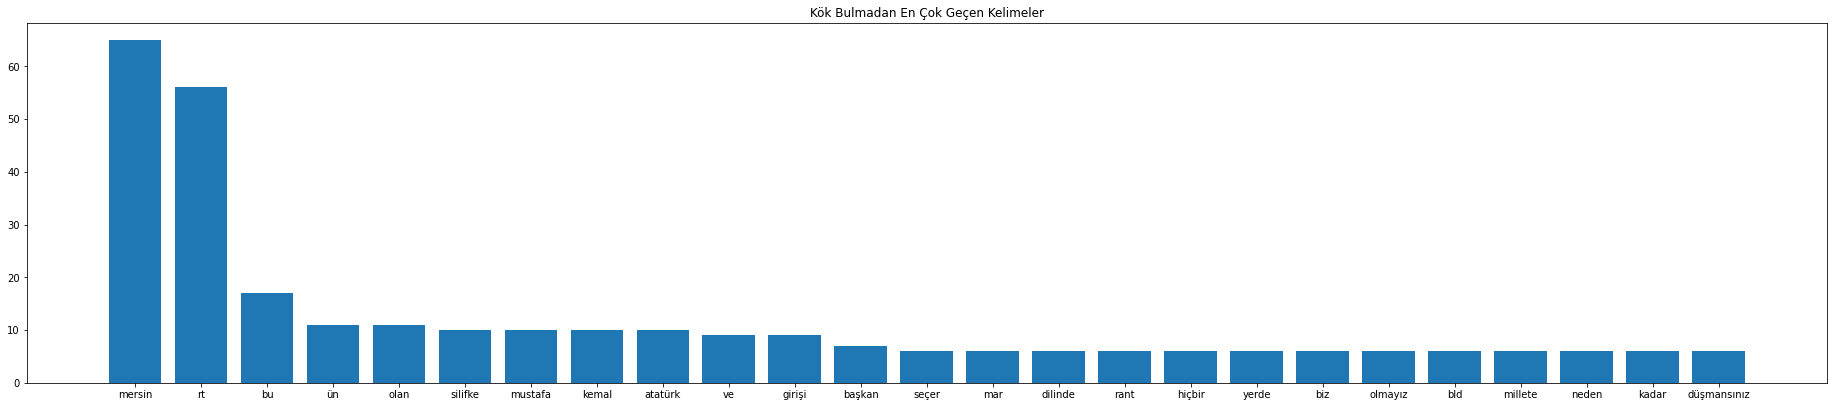

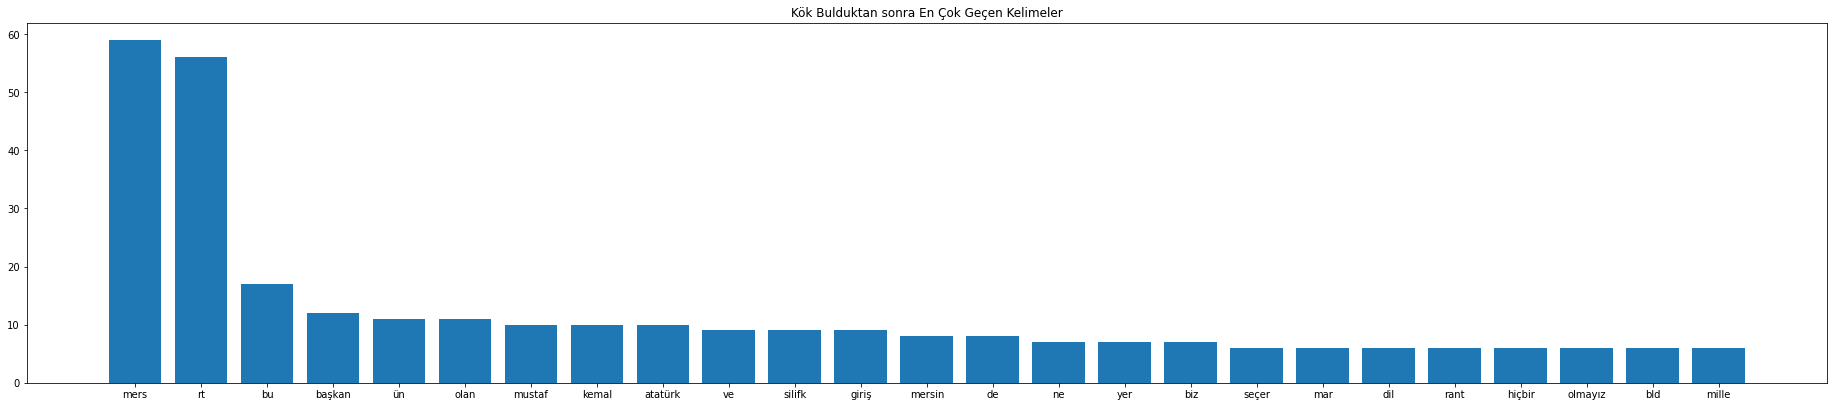

In [26]:
common_words = get_top_n_words(data['Text'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.title('Kök Bulmadan En Çok Geçen Kelimeler')
plt.show()


common_words = get_top_n_words(data['stemmed'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.title('Kök Bulduktan sonra En Çok Geçen Kelimeler')
plt.show()

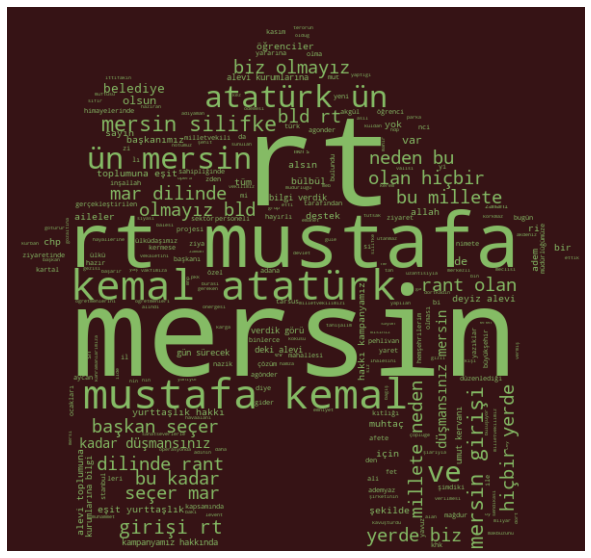

In [33]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#85bb65"

text = " ".join(review for review in data.Text)

wine_mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png', stream=True).raw))
wc = WordCloud(background_color="rgba(54,19,21,255)", mode="RGBA", max_words=250, mask=wine_mask, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("faruk.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

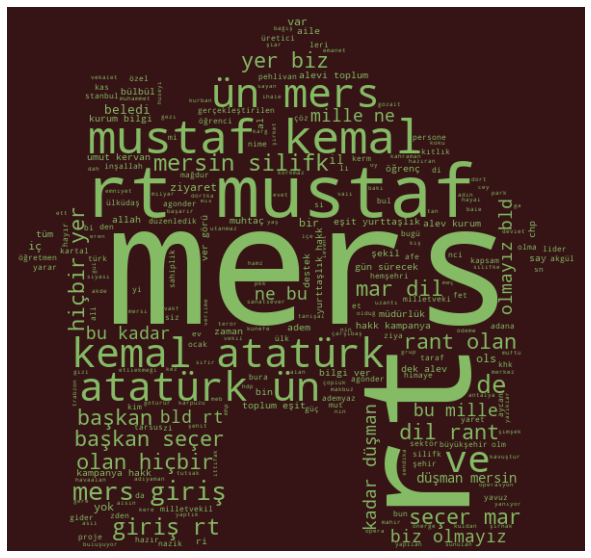

In [35]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#85bb65"

text = " ".join(review for review in data.stemmed)

wine_mask = np.array(Image.open(requests.get("http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png", stream=True).raw))
wc = WordCloud(background_color="rgba(54,19,21,255)", mode="RGBA", max_words=250, mask=wine_mask, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()